<a href="https://colab.research.google.com/github/brentdevetter/classifiers/blob/master/SVM_breastcancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Support Vector Machines (SVM)

SVMs are a supervised machine learning technique useful for classification and regression. A decision boundary (called a hyperplane) is drawn between a dataset. The decision boundary is found by selecting the furthest away hyperplane (maximize the margin) from any data point. Data points separating the hyperplane are called support vectors. 

A good tutorial on SVM math is here: https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-2/ and https://pythonprogramming.net/support-vector-machine-fundamentals-machine-learning-tutorial/

A hyperplane is defined as: 
$$ \mathbf{w^T} \cdot x = 0 $$

Two constraints: 

If a vector $\mathbf{x}_i$ is in class 1 then: 
$$ \mathbf{w^T} \cdot \mathbf{x} + b \geq 1  $$

If a vector $\mathbf{x}_i$ is in class -1 then: 
$$ \mathbf{w^T} \cdot \mathbf{x} + b \leq -1  $$

The margin is found by 
$$ m = \frac{2}{||\mathbf{w}||}$$

As described elsewhere these constraints and the margin lead to a minimization problem.

In [0]:
# Demonstration of SVM classification using the Wisconsin Breast Cancer
# data from UCI. 
# 
# Goal: a) demonstrate data loading & cleaning using Pandas
#       b) visualization using seaborn, matplotlib
#       c) machine learning & analysis using scikit-learn
#      
# References:
#     1. https://engmrk.com/module-16-support-vector-machine-2/
#     2. https://www.kaggle.com/duyguyakar/introduction-to-python-with-breast-cancer-data-set
#     3. https://www.kaggle.com/rohithpai/breast-cancer-data-statistical-analysis/data
#     4. https://www.kaggle.com/rcfreitas/python-ml-breast-cancer-diagnostic-data-set
#
# 2019; http://github.com/brentdevetter

# Import libraries 
import numpy as np               # Arrays & math
import seaborn as sns            # Tools for plotting & visualization
import pandas as pd              # Data loading & manipulation
import matplotlib.pyplot as plt  # Plotting 

# Necessary for loading dataset from Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')
data = pd.read_csv('gdrive/My Drive/Colab Notebooks/wdbc.csv')

%matplotlib inline
sns.set_style("darkgrid")

# Display information about the raw data
print(data.head(3))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38           122.8     1001.0   
1    842517         M        20.57         17.77           132.9     1326.0   
2  84300903         M        19.69         21.25           130.0     1203.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   

      ...       texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0     ...               17.33            184.6      2019.0            0.1622   
1     ...               23.41            158.8      1956.0            0.1238   
2  

In [0]:
# Remove the last row because there is no data there.
data.drop(data.columns[[-1, 0]], axis=1, inplace=True)
data.info()

print("The dataset has {0} columns and {1} rows".format(data.shape[0], data.shape[1]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

The breast cancer data contains 30 columns coresponding to various biomarkers of 569 patients. The remaining column contains the diagnosis: B (benign) or M (malignant). We can tabulate the number of B and M cases: 


There are a total of 569 diagnoses. There were 357 benign cases and 212 malignant cases.


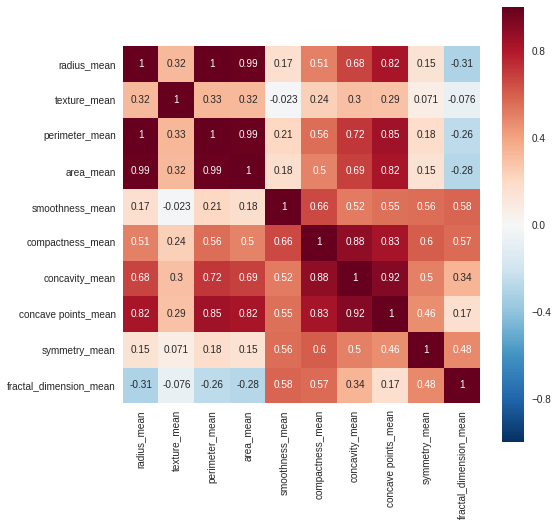

In [0]:
diagnosis_all = list(data.shape)[0]
diagnosis_categories = list(data['diagnosis'].value_counts())

print("There are a total of {0} diagnoses. There were {1} benign cases and {2} malignant cases.".format(diagnosis_all, 
                                                                                                        diagnosis_categories[0],
                                                                                                        diagnosis_categories[1]))

# Let's only look at the average features for now
mean_features = list(data.columns[1:11])

# Take the correlation of the mean features and display a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(data[mean_features].corr(), annot=True, square=True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


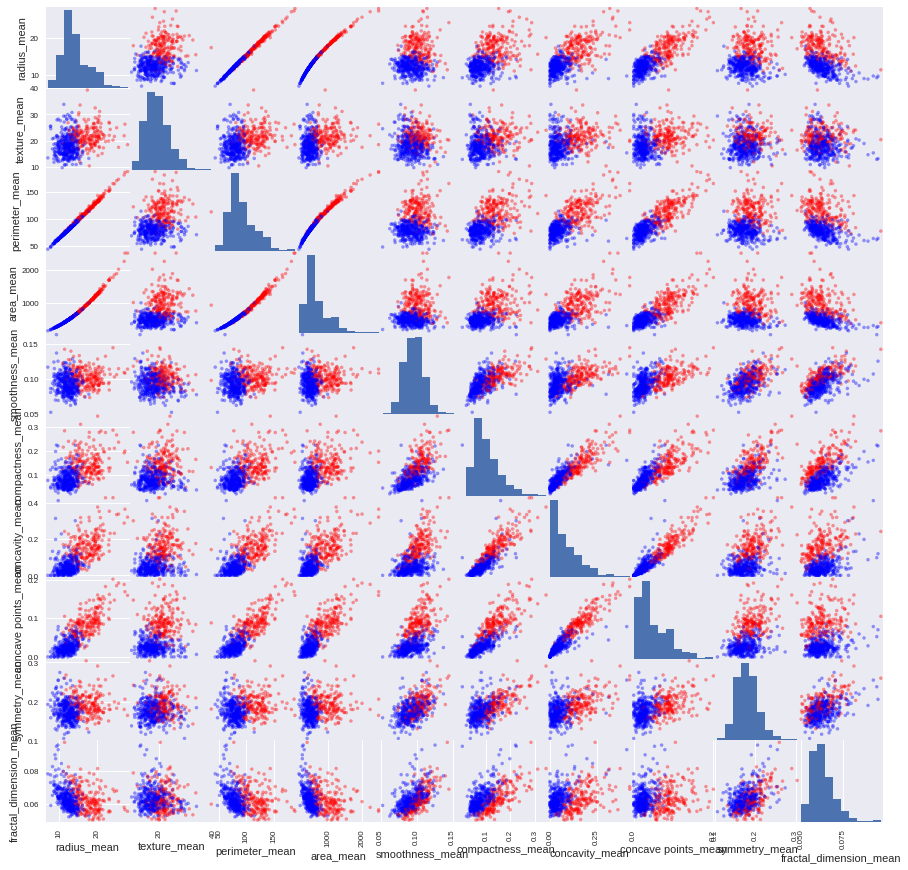

In [0]:
# Plot a scatter matrix to get a feeling for how the mean data is spread 
# across M and B cancer

color_dic = {'M':'red', 'B':'blue'}
colors = data['diagnosis'].map(lambda x: color_dic.get(x))

sm = pd.scatter_matrix(data[mean_features], c=colors, alpha=0.4, figsize=((15,15)));
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


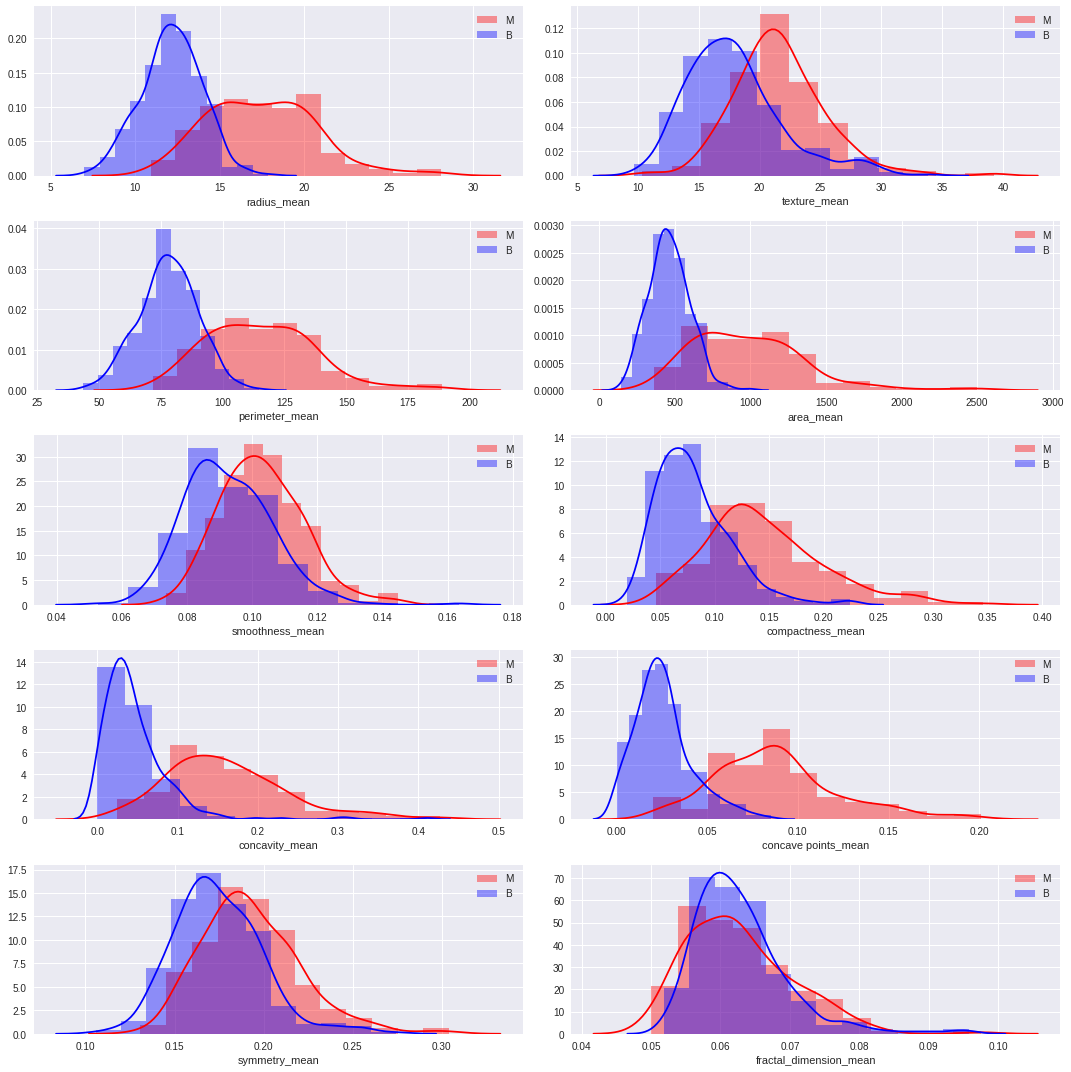

In [0]:
bins = 12
plt.figure(figsize=(15,15))
for i, feature in enumerate(mean_features):
    rows = int(len(mean_features)/2)
    
    plt.subplot(rows, 2, i+1)
    
    sns.distplot(data[data['diagnosis']=='M'][feature], bins=bins, color='red', label='M');
    sns.distplot(data[data['diagnosis']=='B'][feature], bins=bins, color='blue', label='B');
    
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

diag_map = {'M':1, 'B':0}
data['diagnosis'] = data['diagnosis'].map(diag_map)


In [0]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

X = data.loc[:,mean_features]
y = data.loc[:, 'diagnosis']

# Split the dataset into a training set and a test set
# This allows us to test how good our classification algorithm is working!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

accuracy_all = []
cvs_all = []

print("Size of training set: {0}".format(X_train.shape[0]))
print("Size of test set: {0}".format(X_test.shape[0]))

Size of training set: 455
Size of test set: 114


In [0]:
from sklearn.svm import SVC, NuSVC

# First, try a linear SVC
clf = SVC(kernel='linear', gamma='auto')
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=4)

print("Linear SVC Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

# NuSVC limits the number of support vectors
clf = NuSVC(gamma='auto')
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=5)

print("NuSVC Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

Linear SVC Accuracy: 93.86%
Cross validation score: 89.99% (+/- 5.94%)
NuSVC Accuracy: 71.05%
Cross validation score: 71.88% (+/- 3.97%)
